# Sensitivity Assessment

## Motivation

The study I did where I assessed the impact of higher $\Delta \eta_{hh}$ categories was based on the baseline analysis with the MDR+$\min D_{hh}$ paring algorithm which also included the MDpT cuts.

However, from my pairing and flows studies, I learned that these MDpT and MDR cuts both seem to be preferentially cutting out the higher $\Delta \eta_{hh}$ regions, which means I think I can get a "first guess" on this answer with some of the studies that Sean trained.


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path+= ['../RRevolution/code/','../PAG-opt/','../code/']
from analysis import getXhh
from utils import mcToYr, L

from eventDisplays import rainbow_text

from plots import draw_SR, draw_VR, draw_CR

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [3]:
physicsSample='SMNR'
mc='mc16e'
yr = mcToYr[mc]-2000

In [4]:
scols = ['m_hh','m_h1','m_h2','mc_sf','dEta_hh','X_wt','ntag','pass_vbf_sel','truth_mhh']
bcols = ['m_hh','m_h1','m_h2','dEta_hh','X_wt_tag','ntag',
         f'NN_d24_weight_bstrap_med_{yr}', f'NN_d24_weight_VRderiv_bstrap_med_{yr}',
         f'NN_d24_weight_bstrap_IQR_{yr}']

In [5]:
x1,y1 = 124,117

In [6]:
fDir = '/u/ki/nhartman/gpfs/diHiggs4b/data/RR/nom_trigs_unblind'
rwTag = f'_min_dR_VEC_sr_{x1}_{y1}_NN_100_bootstraps'

tName = 'sig'


# If I decide I want a single nb to run *all* of the years (later on)
# f16 = uproot.open(f'{fDir}/data16{rwTag}.root')
# b16 = f16[tName].pandas.df(cols+['NN_d24_weight_bstrap_med_16'])

# f17 = uproot.open(f'{fDir}/data17{rwTag}.root')
# b17 = f17[tName].pandas.df(cols+['NN_d24_weight_bstrap_med_17'])

# f18 = uproot.open(f'{fDir}/data18{rwTag}.root')
# b18 = f18[tName].pandas.df(cols+['NN_d24_weight_bstrap_med_18'])

# Apply the normalization correction to the weights
# for yr,bdf,f in zip([16,17,18],[b16,b17,b18],[f16,f17,f18]):
#     bdf['w_2b'] = f[f'NN_norm_bstrap_med_{yr}']._fVal * bdf[f'NN_d24_weight_bstrap_med_{yr}']

# Recall - Sean's already applied the VBF veto
# b16 = b16[b16.ntag==2]
# b17 = b17[b17.ntag==2]
# b18 = b18[b18.ntag==2]


f = uproot.open(f'{fDir}/data{yr}{rwTag}.root')
bdf = f[tName].pandas.df(bcols)

bdf['w_2b'] = f[f'NN_norm_bstrap_med_{yr}']._fVal * bdf[f'NN_d24_weight_bstrap_med_{yr}']
bdf = bdf[bdf.ntag==2]

f.close()

In [7]:
# sFile = '../data/RR/NNT_DEC20_MDR_VEC/MC/600043_mc16{}/NanoNTuple.root'
# tName = 'fullmassplane'
# s16 = uproot.open(sFile.format('a'))[tName].pandas.df(cols+scols)
# s17 = uproot.open(sFile.format('d'))[tName].pandas.df(cols+scols)
# s18 = uproot.open(sFile.format('e'))[tName].pandas.df(cols+scols)
# # Apply the lumi uncertainty - and calculate the *new* SR / cut the unwanted events
# for yr,sdf in zip([16,17,18],[s16,s17,s18]):
#     sdf['mc_sf']     *= L[yr]
#     sdf['truth_mhh'] *= 0.001
#     sdf['Xhh_new'] = getXhh(*sdf[['m_h1','m_h2']].values.T,x1,y1)

# s16 = s16[(s16.Xhh_new < 1.6) & (s16.ntag>=4) & (~s16.pass_vbf_sel)]
# s17 = s17[(s17.Xhh_new < 1.6) & (s17.ntag>=4) & (~s17.pass_vbf_sel)]
# s18 = s18[(s18.Xhh_new < 1.6) & (s18.ntag>=4) & (~s18.pass_vbf_sel)]



sFile = f'../data/RR/NNT_DEC20_MDR_VEC/MC/600043_{mc}/NanoNTuple.root'
tName = 'fullmassplane'
sdf = uproot.open(sFile)[tName].pandas.df(scols)

# Apply the lumi uncertainty - and calculate the *new* SR / cut the unwanted events
sdf['mc_sf']     *= L[yr]
sdf['truth_mhh'] *= 0.001

sdf['Xhh_new'] = getXhh(*sdf[['m_h1','m_h2']].values.T,x1,y1)

sdf = sdf[(sdf.Xhh_new < 1.6) & (sdf.ntag>=4) & (~sdf.pass_vbf_sel)]


### Sensitivity estimate

Let's just get that classic s vs b plot for $\Delta \eta_{hh}$ above and below our cut boundary and a *first* significance estimate rn.

In [8]:
n,r = 40, (200,1200)

In [9]:
text = "$\mathbf{ATLAS}$ "+f"Data 20{yr} Internal\n"
text += f"min_dR1, X_wt_tag, res bkts"

In [10]:
figDir = f'figures/data{yr}_sr_{x1}_{y1}'
title = f'4b SR ({x1},{y1})'

In [11]:
r = 200

fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2,0],sharex=ax1)


s,e,_ = ax1.hist(sdf['dEta_hh'],15,(0,1.5), color='rebeccapurple', histtype='step',lw=4,
                 label=f'SM x {r}', weights=r*sdf['mc_sf'])

b,e,_ = ax1.hist(bdf['dEta_hh'],15,(0,1.5), color='grey',histtype='step',lw=4,
                 label='rw inclusive', weights=bdf['w_2b'])


xx = 0.5*(e[1:]+e[:-1])
z = s/(r*np.sqrt(b))
plt.plot(xx,z,color='rebeccapurple',lw=0,marker='o')

ax2.set_xlabel('$|\Delta \eta_{hh}|$',fontsize=18)
ax1.set_ylabel('Entries',fontsize=18)
ax2.set_ylabel('$s \ / \ \sqrt{b}$',fontsize=18)
ax1.legend(loc='upper right',bbox_to_anchor=(1,.8))

ax1.set_xlim(0,1.5)

plt.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=10)

ax1.set_title(title,loc='right')

# Add some significane text
_,ymax = ax2.get_ylim()
ax2.set_ylim(0,1.2*ymax)

ti = f'z = {np.sqrt(np.sum(z**2)):.2f}'
    
rainbow_text(1.4,ymax, [ti],['rebeccapurple'], yoffset=1.1,ax=ax2,
             ha='right',va='top',fontsize=18)


plt.savefig(f'{figDir}/abs_deta_hh_SR.pdf',bbox_inches='tight')

In [55]:

eta_edgs = np.linspace(0,1.5,4)

idx = ['nom'] + [f'{emin},{emax}' for emin,emax in zip(eta_edgs[:-1],eta_edgs[1:])]
cols = ['SR']
zs = pd.DataFrame(0,idx,cols)


nCats = len(eta_edgs) - 1
eta_edgs



array([0. , 0.5, 1. , 1.5])

In [56]:
fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = ax1.twinx()
ax3 = fig.add_subplot(gs[2,0],sharex=ax1)

ls = []
lc = []

n = 40
r = (200,1200)

for i,eta_min, eta_max in zip(range(len(eta_edgs)),eta_edgs[:-1],eta_edgs[1:]):

    c=f'C{i}'
    
    smask = (sdf.dEta_hh > eta_min) & (sdf.dEta_hh < eta_max)
    s,e,_ = ax1.hist(sdf.loc[smask,'m_hh'].values,n,r,histtype='step',color=c,lw=4,
                     label=f'{eta_min:.1f} < '+'$\Delta \eta_{hh}$'+f'< {eta_max:.1f}', 
                     weights=sdf.loc[smask,'mc_sf'].values)
    
    bmask = (bdf.dEta_hh > eta_min) & (bdf.dEta_hh < eta_max)
    b,_,_ = ax2.hist(bdf.loc[bmask,'m_hh'],n,r, histtype='step',color=c,lw=4,ls='--',
                     weights=bdf.loc[bmask,'w_2b'])
    
    xx = 0.5 * (e[1:] + e[:-1])
    z = s/np.sqrt(b)
    
    ax3.plot(xx,z,lw=0,marker='.',color=c)
    zi = np.sqrt(np.sum(z[b!=0]**2))
    ls.append(f'z={zi:.3f}')
    lc.append(c)
    zs.loc[f'{eta_min},{eta_max}','SR'] = zi
    
    
for l,s in zip(['SM NR','rw 2b'],['-','--']):
    ax2.plot([],[],label=l,ls=s,color='grey')
    
ax3.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
ax1.set_ylabel('Signal entries',fontsize=18)
ax2.set_ylabel('Background entries',fontsize=18,rotation=270,labelpad=20)
ax3.set_ylabel('s$ / \sqrt{b}$',fontsize=18)

ax1.legend(loc='upper right',bbox_to_anchor=(1,.72),fontsize=12)
ax2.legend(loc='upper left',bbox_to_anchor=(.57,1), fontsize=18)

plt.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=12)
ax1.set_title(title,loc='right')

rainbow_text(1200,.032, ls,lc, yoffset=.95,ax=ax3,fontsize=12,ha='right')

# nCats = len(eta_edgs) - 1
plt.savefig(f'{figDir}/m_hh_SR_{nCats}_deta_cats.pdf',bbox_inches='tight')

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [45]:
zs

SR
nom       0.000000
0.0,0.25  0.133817
0.25,0.5  0.125675
0.5,0.75  0.102411
0.75,1.0  0.081570
1.0,1.25  0.061072
1.25,1.5  0.043901

In [46]:
0.179736*1.115

0.20040564

In [47]:
np.sqrt(.148**2 + .113**2)/zs.loc['nom','SR']

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


inf

Just the nominal histogram

In [48]:
s,e,_ = ax1.hist(sdf.m_hh.values,n,r,histtype='step',color=c,lw=4,
                 label=f'{eta_min} < '+'$\Delta \eta_{hh}$'+f'< {eta_max}', 
                 weights=sdf.mc_sf.values)

b,_,_ = ax2.hist(bdf.m_hh.values,n,r, histtype='step',color=c,lw=4,ls='--',
                 weights=bdf.w_2b.values)

z = s/np.sqrt(b)
zs.loc[f'nom','SR'] = np.sqrt(np.sum(z[b!=0]**2))

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


**Goal:** Let's try to visualize the extra improvement we get from this $|\Delta \eta_{hh}|$ category.

1.0971731105342515


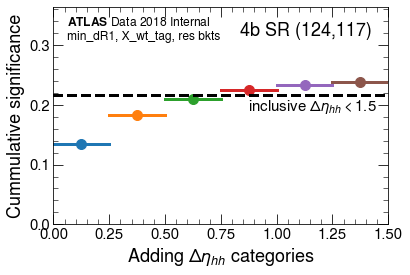

In [50]:
plt.plot(eta_edgs,zs.loc['nom','SR']*np.ones_like(eta_edgs),'k--')

z_tot = 0

for i,eta_min, eta_max in zip(range(nCats),eta_edgs[:-1],eta_edgs[1:]):

    c=f'C{i}'

    z_tot = np.sqrt(z_tot**2 + zs.loc[f'{eta_min},{eta_max}','SR']**2)
    
    eta_avg = 0.5 * (eta_min + eta_max)
    plt.scatter(eta_avg,z_tot,100,color=c)
    plt.plot([eta_min, eta_max],np.ones(2)*z_tot,c)

plt.xlabel('Adding $\Delta \eta_{hh}$ categories',fontsize=18)
plt.ylabel('Cummulative significance',fontsize=18)

_,ymax = plt.ylim()
plt.ylim(0,1.5*ymax)
plt.xlim(eta_edgs[[0,-1]])

ax = plt.gca()
plt.text(0.04,.96,text,ha='left',va='top',transform=ax.transAxes,fontsize=12)

plt.text(.95,.93,title,ha='right',va='top',transform=ax.transAxes,fontsize=18)

xloc=1.45
eps=.004
plt.text(xloc, zs.loc['nom','SR']-eps,'inclusive $\Delta \eta_{hh} < 1.5$',
         ha='right',va='top')

print(z_tot / zs.loc['nom','SR'])

#plt.text(xloc, zs.loc['rev','SR'],'inclusive $\Delta \eta_{hh} > 1.5$',va='bottom',color='dimgrey')

#nCats = len(eta_edgs) - 1
plt.savefig(f'{figDir}/significance_SR_{nCats}_deta_cats.pdf',bbox_inches='tight')

In [40]:
z_tot

0.23575526697474844

Rafael was *also* curious to see the individual significances.

In [52]:
figDir

'figures/data18_sr_124_117'

In [51]:
plt.plot(eta_edgs,zs.loc['nom','SR']*np.ones_like(eta_edgs),'k--')

z_tot = 0

for i,eta_min, eta_max in zip(range(len(eta_edgs)),eta_edgs[:-1],eta_edgs[1:]):

    c=f'C{i}'

    #z_tot = np.sqrt(z_tot**2 + zs.loc[f'{eta_min},{eta_max}','SR']**2)
    
    eta_avg = 0.5 * (eta_min + eta_max)
    zi = zs.loc[f'{eta_min},{eta_max}','SR']
    plt.scatter(eta_avg,zi,100,color=c)
    plt.plot([eta_min, eta_max],np.ones(2)*zi,c)

plt.xlabel('Adding $\Delta \eta_{hh}$ categories',fontsize=18)
plt.ylabel('Individual significance',fontsize=18)

plt.ylim(0,1.5*ymax)
plt.xlim(eta_edgs[[0,-1]])

ax = plt.gca()
plt.text(0.04,.96,text,ha='left',va='top',transform=ax.transAxes,fontsize=12)
plt.text(.93,.9,title,ha='right',va='top',transform=ax.transAxes,fontsize=18)

plt.text(xloc, zs.loc['nom','SR']-eps,'inclusive $\Delta \eta_{hh} < 1.5$',ha='right',va='top')

plt.savefig(f'{figDir}/significance_ind_SR_{nCats}_deta_cats.pdf',bbox_inches='tight')

**Rafael's prescription:** Bin more finely, and then for each category, plot (per bin) $s/\sqrt{b}$ vs $\Delta \eta_{hh}$ (*not* cummulative) and then define the **cut** as the peak of this significance distribution for $\Delta \eta_{hh}$, then *rinse + repeat* haha.

**Implementation details:**

I think @ this stage, it probably isn't as useful to make all of the histograms, so I'm going to make a *function* $\Delta \eta_{hh}$ to 
(1)


(I'll run through some choices with Sean's binning for NR studies, and then rinse + repeat w/ Patrick's bins.)

In [24]:
def getSignificance(sdf,bdf,mhh_edg,eta_edg):
    '''
    Goal: So this will be a *little* bit of a rinse + repeat process, 
    but this fct calculates the m_hh significance w/r.t. eta edges.
    
    Returns: zs quad sum m_hh sig w/ len size(eta_edg)-1
    
    '''
    
    zs = []
    for i,eta_min, eta_max in zip(range(len(eta_edg)),eta_edg[:-1],eta_edg[1:]):

        smask = (sdf.dEta_hh > eta_min) & (sdf.dEta_hh < eta_max)
        s = np.histogram(sdf.loc[smask,'m_hh'].values, mhh_edg, weights=sdf.loc[smask,'mc_sf'].values)[0]

        bmask = (bdf.dEta_hh > eta_min) & (bdf.dEta_hh < eta_max)
        b = np.histogram(bdf.loc[bmask,'m_hh'].values, mhh_edg, weights=bdf.loc[bmask,'w_2b'].values)[0]

        z = s/np.sqrt(b)
        zs.append(np.sqrt(np.sum(z[b!=0]**2)))
    
    return np.array(zs)
    

In [25]:
es = np.linspace(200,1200,41)
er = np.linspace(250,1250,71)
ep = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
               537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
               1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])



**Cool!** Let's *start* out the anlaysis w/ Sean's bins :-)

In [26]:
eta1 = np.linspace(0,1.5,25)
eta1

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    , 1.0625, 1.125 , 1.1875, 1.25  , 1.3125, 1.375 , 1.4375,
       1.5   ])

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


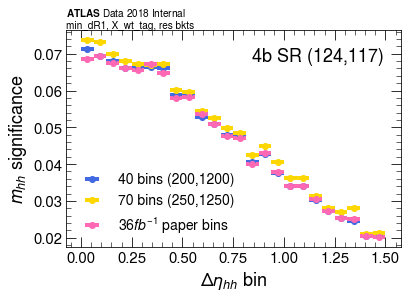

In [27]:
colors = ['royalblue','gold','hotpink']
labels = ['40 bins (200,1200)','70 bins (250,1250)','36$fb^{-1}$ paper bins']

zs1 = getSignificance(sdf,bdf,es,eta1)

x1 = 0.5 * (eta1[1:]+eta1[:-1])
w1 = 0.5 * (eta1[1:]-eta1[:-1])

kwargs = {'xerr':w1, 'lw':0, 'elinewidth':4, 'marker':'o'}

for ei, c, l in zip([es,er,ep],colors,labels):
    
    zi = getSignificance(sdf,bdf,ei,eta1)

    plt.errorbar(x1,zi,color=c,label=l,**kwargs)

plt.xlabel('$\Delta \eta_{hh}$ bin',fontsize=18)
plt.ylabel('$m_{hh}$ significance',fontsize=18)
plt.legend(loc='lower left')

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)
plt.text(.95,.92,title,ha='right',va='top',transform=ax.transAxes,fontsize=18)

plt.savefig(f'{figDir}/first_deta_hh_cat_cf_mhh_bins.pdf',bbox_inches='tight')


Ok - I found it *quite* surprising that the 70 bins was giving the best stat only significance, so I'm going to try to see which $m_{hh}$ bins are driving this trend by making the $\Delta \eta_{hh}$ plots, but applying a $\Delta \eta_{hh}$ < 0.25 cut.

In [28]:
ls = []
lc = []

eta_max = 0.25
smask = (sdf.dEta_hh < eta_max)
bmask = (bdf.dEta_hh < eta_max)

for e,c,l in zip([es,er,ep],colors,labels):
     
    xx = 0.5 * (e[1:] + e[:-1])
    w  = 0.5 * (e[1:] - e[:-1])
    
    plt.figure(0)
    #hargs = {'bins':e, 'histtype':'step', 'color':c, 'lw':4, 'label':l}
    eargs = {'xerr':w, 'color':c, 'label':l, 'lw':0, 'elinewidth':4, 'marker':'o'}
    
    s = np.histogram(sdf.loc[smask,'m_hh'].values, e, weights=sdf.loc[smask,'mc_sf'].values)[0]
    s_err = np.sqrt(np.histogram(sdf.loc[smask,'m_hh'].values,e,weights=sdf.loc[smask,'mc_sf'].values**2)[0])

    plt.errorbar(xx,s/w,s_err/w,**eargs)
    

    plt.figure(1)
    
    b = np.histogram(bdf.loc[bmask,'m_hh'].values, e, weights=bdf.loc[bmask,'w_2b'].values)[0]
    b_err = np.sqrt(np.histogram(bdf.loc[bmask,'m_hh'].values,e,weights=bdf.loc[bmask,'w_2b'].values**2)[0])

    plt.errorbar(xx,b/w,b_err/w,**eargs)
    
    plt.figure(2)
    z = s/np.sqrt(b)
    z_err = s_err/b
    
    plt.errorbar(xx,z,z_err,**eargs)
    zi = np.sqrt(np.sum(z[b!=0]**2))
    ze = np.sqrt(np.sum(z_err[b!=0]**2))
    ls.append(f'z={zi:.3f} $\pm$ {ze:.3f}')
    lc.append(c)
    
    
for i, yl in zip(range(3),['Signal events / bin width','Background events / bin width','$s$ / $\sqrt{b}$']):
    
    plt.figure(i)
    
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel(yl,fontsize=18)
    plt.title(title,loc='right')
    plt.legend(loc='upper right')#,bbox_to_anchor=(1,.9))
    
    ax = plt.gca()
    plt.text(.9,.6,'$\Delta \eta_{hh}$'+f' < {eta_max:.2f}',ha='right',va='top',
             transform=ax.transAxes,fontsize=18)
    
    ti = text.replace('Data 2017','Simulation') if 'Signal' in yl else text
    plt.text(0,1,ti,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)
    
rainbow_text(200,.045, ls,lc, yoffset=1.2,ax=ax,fontsize=12,ha='left')

# Bound the sig plot
plt.ylim(0,.05)

#plt.savefig(f'{figDir}/m_hh_SR_{nCats}_deta_cats.pdf',bbox_inches='tight')

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


(0.0, 0.05)

In [29]:
ls = []
lc = []

eta_max = 0.25
smask = (sdf.dEta_hh > eta_max)
bmask = (bdf.dEta_hh > eta_max)

for e,c,l in zip([es,er,ep],colors,labels):
     
    xx = 0.5 * (e[1:] + e[:-1])
    w  = 0.5 * (e[1:] - e[:-1])
    
    plt.figure(0)
    #hargs = {'bins':e, 'histtype':'step', 'color':c, 'lw':4, 'label':l}
    eargs = {'xerr':w, 'color':c, 'label':l, 'lw':0, 'elinewidth':4, 'marker':'o'}
    
    s = np.histogram(sdf.loc[smask,'m_hh'].values, e, weights=sdf.loc[smask,'mc_sf'].values)[0]
    s_err = np.sqrt(np.histogram(sdf.loc[smask,'m_hh'].values,e,weights=sdf.loc[smask,'mc_sf'].values**2)[0])

    plt.errorbar(xx,s/w,s_err/w,**eargs)
    

    plt.figure(1)
    
    b = np.histogram(bdf.loc[bmask,'m_hh'].values, e, weights=bdf.loc[bmask,'w_2b'].values)[0]
    b_err = np.sqrt(np.histogram(bdf.loc[bmask,'m_hh'].values,e,weights=bdf.loc[bmask,'w_2b'].values**2)[0])

    plt.errorbar(xx,b/w,b_err/w,**eargs)
    
    plt.figure(2)
    z = s/np.sqrt(b)
    z_err = s_err/b
    
    plt.errorbar(xx,z,z_err,**eargs)
    zi = np.sqrt(np.sum(z[b!=0]**2))
    ze = np.sqrt(np.sum(z_err[b!=0]**2))
    ls.append(f'z={zi:.3f} $\pm$ {ze:.3f}')
    lc.append(c)
    
    
for i, yl in zip(range(3),['Signal events / bin width','Background events / bin width','$s$ / $\sqrt{b}$']):
    
    plt.figure(i)
    
    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel(yl,fontsize=18)
    plt.title(title,loc='right')
    plt.legend(loc='upper right')#,bbox_to_anchor=(1,.9))
    
    ax = plt.gca()
    plt.text(.9,.6,'$\Delta \eta_{hh}$'+f' > {eta_max:.2f}',ha='right',va='top',
             transform=ax.transAxes,fontsize=18)
    
    ti = text.replace('Data 2017','Simulation') if 'Signal' in yl else text
    plt.text(0,1,ti,ha='left',va='bottom',transform=ax.transAxes,fontsize=12)
    
rainbow_text(200,.045, ls,lc, yoffset=1.2,ax=ax,fontsize=12,ha='left')

# Bound the sig plot
plt.ylim(0,.05)

#plt.savefig(f'{figDir}/m_hh_SR_{nCats}_deta_cats.pdf',bbox_inches='tight')

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


(0.0, 0.05)

Ok - it would be a *good* idea to keep digging in, but I think since my plots were *not* dependent on the particular choice of binning, it's fine to j stick w/ 0.25 and keep going w/ the Rafael prescription haha.

In [30]:
eta1[4:]

array([0.25  , 0.3125, 0.375 , 0.4375, 0.5   , 0.5625, 0.625 , 0.6875,
       0.75  , 0.8125, 0.875 , 0.9375, 1.    , 1.0625, 1.125 , 1.1875,
       1.25  , 1.3125, 1.375 , 1.4375, 1.5   ])

In [31]:
eta2 = np.linspace(0.25,1.5,21)
print(eta2)

x2 = 0.5 * (eta2[1:]+eta2[:-1])
w2 = 0.5 * (eta2[1:]-eta2[:-1])

kwargs = {'xerr':w2, 'lw':0, 'elinewidth':4, 'marker':'o'}

for ei, c, l in zip([es,er,ep],colors,labels):
    
    zi = getSignificance(sdf,bdf,ei,eta2)

    plt.errorbar(x2,zi,color=c,label=l,**kwargs)

plt.xlabel('$\Delta \eta_{hh}$ bin',fontsize=18)
plt.ylabel('$m_{hh}$ significance',fontsize=18)
plt.legend(loc='lower left')

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)
plt.text(.95,.92,title,ha='right',va='top',transform=ax.transAxes,fontsize=18)

#plt.savefig(f'{figDir}/first_deta_hh_cat_cf_mhh_bins.pdf',bbox_inches='tight')



[0.25   0.3125 0.375  0.4375 0.5    0.5625 0.625  0.6875 0.75   0.8125
 0.875  0.9375 1.     1.0625 1.125  1.1875 1.25   1.3125 1.375  1.4375
 1.5   ]


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


Text(0.95, 0.92, '4b SR (124,117)')